In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

2022-02-04 17:28:08.259365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [3]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]

In [4]:
rfparam_keys = ["chirp", "curv", "skew", "l1", "l2", "A1.v", "A1.phi", "AH1.v", "AH1.phi", "L1.v",
                "L1.phi", "L2.v", "L2.phi"]
rfparams = [[sample[k] for k in rfparam_keys] for sample in data]

In [5]:
del data

In [6]:
filtered_currents = [(s, current) for s, current in currents if current.max() > 1000]
filtered_rfparams = [sample for sample, (_, current) in zip(rfparams, currents) if current.max() > 1000]

In [7]:
def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors = np.array([current2formfactor(*current, grating="both") for current in filtered_currents])

In [8]:
X = list(zip(filtered_rfparams, formfactors))
y = filtered_currents

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### ANN Fixed THz

In [10]:
formfactors_train = [ff for _, ff in X_train]
filtered_train = y_train

formfactors_test = [ff for _, ff in X_test]
filtered_test = y_test

In [11]:
def shift_onto_center_of_mass(s, current):
    """Shift a current profile such that its center of mass it at 0."""
    cm = (s * current).sum() / current.sum()
    return s - cm, current

shifted_train = [shift_onto_center_of_mass(s, current) for s, current in filtered_train]
shifted_test = [shift_onto_center_of_mass(s, current) for s, current in filtered_test]

In [12]:
# limit = max(max(np.abs(s)) for s, _ in shifted)
limit = 70e-6
new_s = np.linspace(-limit, limit, 100)

interpolated_train = [(new_s, np.interp(new_s, s, current, left=0, right=0)) for s, current in shifted_train]
interpolated_test = [(new_s, np.interp(new_s, s, current, left=0, right=0)) for s, current in shifted_test]

In [13]:
def train(formfactors, currents, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = np.stack([current for _, current in currents])
        
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = 1 / y.max(axis=1).mean()
    y_scaled = y * y_scaler
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y.shape[1], activation="relu")]
    )
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=64, verbose=0)
    
    return model, X_scaler, y_scaler

model_fixed, X_scaler_fixed, y_scaler_fixed = train(formfactors_train, interpolated_train, epochs=1000)

2022-02-04 17:30:28.615910: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-04 17:30:28.620274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-04 17:30:28.705813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:62:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-02-04 17:30:28.706298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-02-04 17:30:28.706335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-

In [14]:
def do_prediction(formfactor, cp, cp_X_scaler, cp_y_scaler):
    X = formfactor.reshape(1, -1)
    
    cp_X_scaled = cp_X_scaler.transform(X)
    cp_y = cp.predict(cp_X_scaled)
    current = cp_y.squeeze() / cp_y_scaler
    
    return current

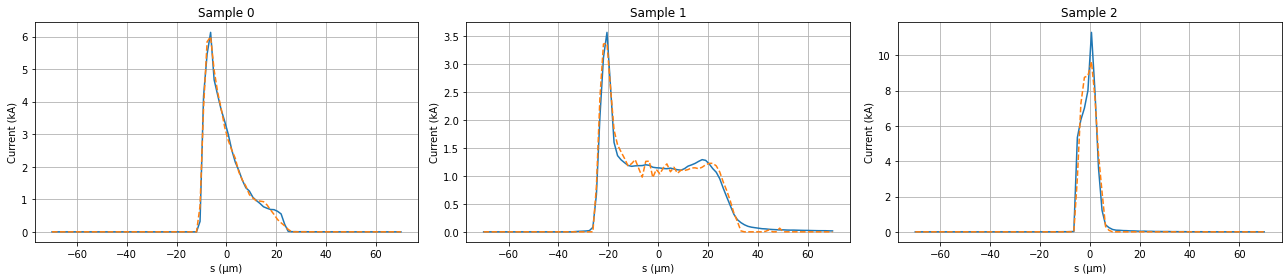

In [15]:
plt.figure(figsize=(18,4))
for i in range(3):
    current_true = interpolated_test[i][1]
    
    formfactor = formfactors_test[i][1]
    current_predict = do_prediction(formfactor, model_fixed, X_scaler_fixed, y_scaler_fixed)
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {i}")
    plt.plot(new_s*1e6, current_true*1e-3, label="Ground Truth")
    plt.plot(new_s*1e6, current_predict*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

### ANN Width THz

In [16]:
formfactors_train = [ff for _, ff in X_train]
filtered_train = y_train

formfactors_test = [ff for _, ff in X_test]
filtered_test = y_test

In [17]:
def compute_max_left(current):
    revcurrent = np.flip(current)
    return np.flip(np.array([revcurrent[i:].max() for i in range(len(current))]))

def compute_max_right(current):
    return np.array([current[i:].max() for i in range(len(current))])

def find_edges(s, current, threshold=0.01):
    max_left = compute_max_left(current)
    left_idx = np.where(max_left >= threshold * max_left.max())[0][0]
    left = s[left_idx]
    
    max_right = compute_max_right(current)
    right_idx = np.where(max_right >= threshold * max_right.max())[0][-1]
    right = s[right_idx]
    
    return left, right

edges_train = np.array([find_edges(s, current) for s, current in filtered_train])
widths_train = edges_train[:,1] - edges_train[:,0]

edges_test = np.array([find_edges(s, current) for s, current in filtered_test])
widths_test = edges_test[:,1] - edges_test[:,0]

In [18]:
def resample(s, current, left, right, n=100):
    new_s = np.linspace(left, right, n)
    new_current = np.interp(new_s, s, current, left=0, right=0)
    return new_s, new_current

interpolated_train = [resample(s, current, left, right) for (s, current), (left, right) in zip(filtered_train, edges_train)]
interpolated_test = [resample(s, current, left, right) for (s, current), (left, right) in zip(filtered_test, edges_test)]

In [19]:
def center_on_zero(s, current, left, right):
    old_center = left + ((right - left) / 2)
    new_s = s - old_center
    return new_s, current

recentered_train = [center_on_zero(s, current, left, right) for (s, current), (left, right) in zip(interpolated_train, edges_train)]
recentered_test = [center_on_zero(s, current, left, right) for (s, current), (left, right) in zip(interpolated_test, edges_test)]

In [20]:
def train_width_predictor(formfactors, widths, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = widths.reshape(-1, 1)
        
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y.shape[1])
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=64, verbose=0)
    
    return model, X_scaler, y_scaler
                                            
wp_width, wp_X_scaler_width, wp_y_scaler_width = train_width_predictor(formfactors_train, widths_train, epochs=1000)

In [21]:
def train_current_predictor(formfactors, currents, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = np.stack([current for _, current in currents])
        
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y.shape[1], activation="relu")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=64, verbose=0)
    
    return model, X_scaler, y_scaler
                                            
cp_width, cp_X_scaler_width, cp_y_scaler_width = train_current_predictor(formfactors_train, recentered_train, epochs=1000)

In [22]:
def do_prediction(formfactor, wp, wp_X_scaler, wp_y_scaler, cp, cp_X_scaler, cp_y_scaler):
    X = formfactor.reshape(1, -1)
    
    wp_X_scaled = wp_X_scaler.transform(X)
    wp_y = wp.predict(wp_X_scaled)
    width = wp_y_scaler.inverse_transform(wp_y).squeeze()
    s = np.linspace(-(width/2), width/2, 100)
    
    cp_X_scaled = cp_X_scaler.transform(X)
    cp_y = cp.predict(cp_X_scaled)
    current = cp_y_scaler.inverse_transform(cp_y).squeeze()
    
    return s, current

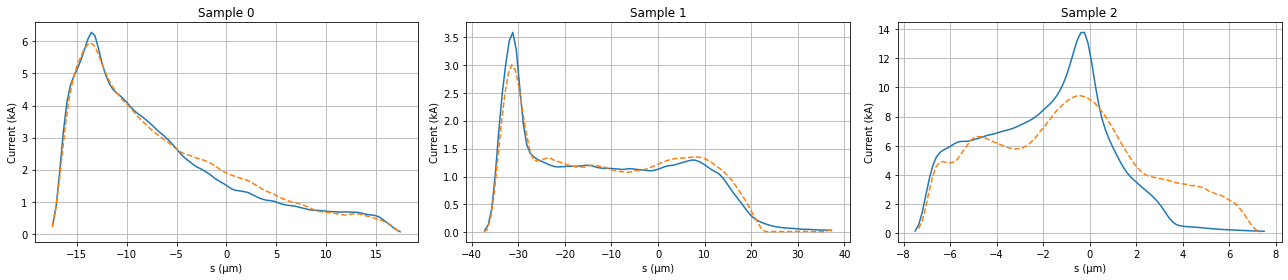

In [23]:
plt.figure(figsize=(18,4))
for i in range(3):
    s_true = recentered_test[i][0]
    current_true = recentered_test[i][1]
    
    formfactor = formfactors_test[i][1]
    s_predict, current_predict = do_prediction(formfactor, wp_width, wp_X_scaler_width, wp_y_scaler_width, cp_width, cp_X_scaler_width, cp_y_scaler_width)
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {i}")
    plt.plot(s_true*1e6, current_true*1e-3, label="Ground Truth")
    plt.plot(s_predict*1e6, current_predict*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

### KNN Width THz

In [37]:
def train_width_predictor(formfactors, widths, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = widths.reshape(-1, 1)
    
    neigh = KNeighborsRegressor(n_neighbors=2, weights="distance")
    neigh.fit(X, y)
        
    return neigh
                                            
wp_knn = train_width_predictor(formfactors_train, widths_train)

In [56]:
def train_current_predictor(formfactors, currents, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = np.stack([current for _, current in currents])
    
    neigh = KNeighborsRegressor(n_neighbors=5, weights="distance")
    neigh.fit(X, y)
        
    return neigh
                                            
cp_knn = train_current_predictor(formfactors_train, recentered_train)

In [57]:
def do_prediction(formfactor, cp, wp):
    X = formfactor.reshape(1, -1)
    
    wp_y = wp.predict(X)
    width = wp_y.squeeze()
    s = np.linspace(-(width/2), width/2, 100)
    
    cp_y = cp.predict(X)
    current = cp_y.squeeze()
    
    return s, current

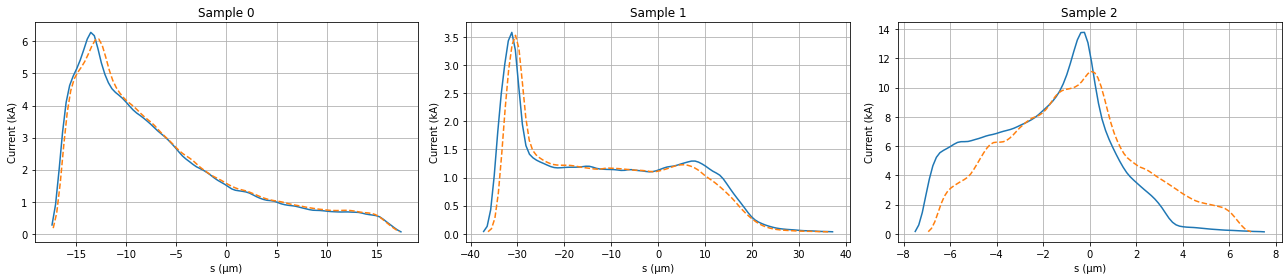

In [58]:
plt.figure(figsize=(18,4))
for i in range(3):
    s_true = recentered_test[i][0]
    current_true = recentered_test[i][1]
    
    formfactor = formfactors_test[i][1]
    s_predict, current_predict = do_prediction(formfactor, cp_knn, wp_knn)
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {i}")
    plt.plot(s_true*1e6, current_true*1e-3, label="Ground Truth")
    plt.plot(s_predict*1e6, current_predict*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

### ANN Width RF

In [28]:
rfparams_train = [rf for rf, _ in X_train]
rfparams_test = [rf for rf, _ in X_test]

In [29]:
def train_width_predictor(rfparams, widths, epochs=500):
    """Train and return model to infer currents from RF parameters."""
    X = np.stack(rfparams)
    y = widths.reshape(-1, 1)
        
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y.shape[1])
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=64, verbose=0)
    
    return model, X_scaler, y_scaler
                                            
wp_rf, wp_X_scaler_rf, wp_y_scaler_rf = train_width_predictor(rfparams_train, widths_train, epochs=1000)

In [30]:
def train_current_predictor(rfparams, currents, epochs=500):
    """Train and return model to infer currents from RF parameters."""
    X = np.stack(rfparams)
    y = np.stack([current for _, current in currents])
        
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y.shape[1], activation="relu")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=64, verbose=0)
    
    return model, X_scaler, y_scaler
                                            
cp_rf, cp_X_scaler_rf, cp_y_scaler_rf = train_current_predictor(rfparams_train, recentered_train, epochs=1000)

In [31]:
def do_prediction(rfparam, wp, wp_X_scaler, wp_y_scaler, cp, cp_X_scaler, cp_y_scaler):
    X = rfparam.reshape(1, -1)
    
    wp_X_scaled = wp_X_scaler.transform(X)
    wp_y = wp.predict(wp_X_scaled)
    width = wp_y_scaler.inverse_transform(wp_y).squeeze()
    s = np.linspace(-(width/2), width/2, 100)
    
    cp_X_scaled = cp_X_scaler.transform(X)
    cp_y = cp.predict(cp_X_scaled)
    current = cp_y_scaler.inverse_transform(cp_y).squeeze()
    
    return s, current

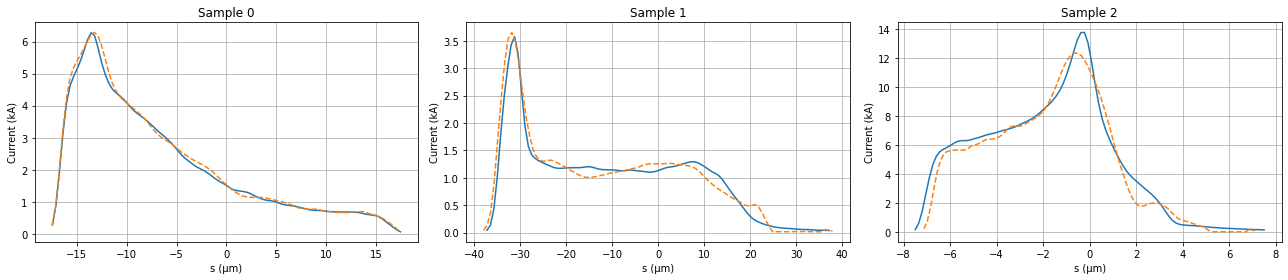

In [32]:
plt.figure(figsize=(18,4))
for i in range(3):
    s_true = recentered_test[i][0]
    current_true = recentered_test[i][1]
    
    rfparam = np.array(rfparams_test[i])
    s_predict, current_predict = do_prediction(rfparam, wp_rf, wp_X_scaler_rf, wp_y_scaler_rf, cp_rf, cp_X_scaler_rf, cp_y_scaler_rf)
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {i}")
    plt.plot(s_true*1e6, current_true*1e-3, label="Ground Truth")
    plt.plot(s_predict*1e6, current_predict*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

### ANN Width RF + THz

In [33]:
def train_width_predictor(rfparams, formfactors, widths, epochs=500):
    """Train and return model to infer currents from RF parameters and formfactors."""
    X1 = np.stack(rfparams)
    X2 = np.stack([formfactor for _, formfactor in formfactors])
    X = np.concatenate([X1,X2], axis=1)
    y = widths.reshape(-1, 1)
        
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y.shape[1], activation="relu")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=64, verbose=0)
    
    return model, X_scaler, y_scaler
                                            
wp_rfthz, wp_X_scaler_rfthz, wp_y_scaler_rfthz = train_width_predictor(rfparams_train, formfactors_train, widths_train, epochs=1000)

In [34]:
def train_current_predictor(rfparams, formfactors, currents, epochs=500):
    """Train and return model to infer currents from RF parameters and formfactors."""
    X1 = np.stack(rfparams)
    X2 = np.stack([formfactor for _, formfactor in formfactors])
    X = np.concatenate([X1,X2], axis=1)
    y = np.stack([current for _, current in currents])
        
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y.shape[1], activation="relu")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=64, verbose=0)
    
    return model, X_scaler, y_scaler
                                            
cp_rfthz, cp_X_scaler_rfthz, cp_y_scaler_rfthz = train_current_predictor(rfparams_train, formfactors_train, recentered_train, epochs=1000)

In [35]:
def do_prediction(rfparam, formfactor, wp, wp_X_scaler, wp_y_scaler, cp, cp_X_scaler, cp_y_scaler):
    X1 = rfparam.reshape(1, -1)
    X2 = formfactor.reshape(1, -1)
    X = np.concatenate([X1,X2], axis=1)
    
    wp_X_scaled = wp_X_scaler.transform(X)
    wp_y = wp.predict(wp_X_scaled)
    width = wp_y_scaler.inverse_transform(wp_y).squeeze()
    s = np.linspace(-(width/2), width/2, 100)
    
    cp_X_scaled = cp_X_scaler.transform(X)
    cp_y = cp.predict(cp_X_scaled)
    current = cp_y_scaler.inverse_transform(cp_y).squeeze()
    
    return s, current

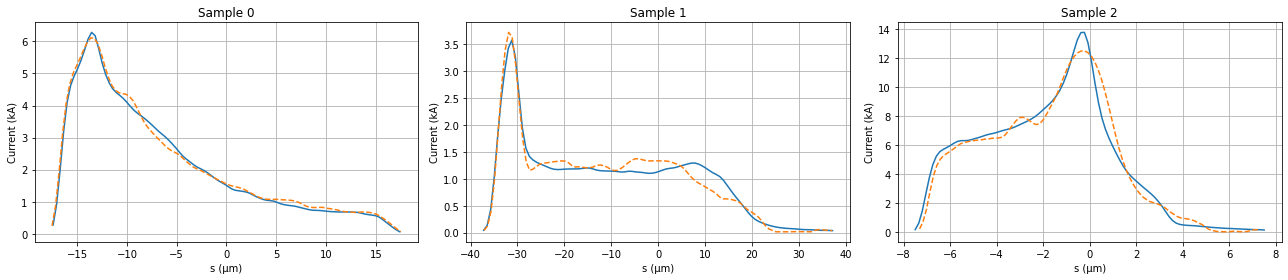

In [36]:
plt.figure(figsize=(18,4))
for i in range(3):
    s_true = recentered_test[i][0]
    current_true = recentered_test[i][1]
    
    rfparam = np.array(rfparams_test[i])
    formfactor = formfactors_test[i][1]
    s_predict, current_predict = do_prediction(rfparam, formfactor, wp_rfthz, wp_X_scaler_rfthz, wp_y_scaler_rfthz, cp_rfthz, cp_X_scaler_rfthz, cp_y_scaler_rfthz)
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {i}")
    plt.plot(s_true*1e6, current_true*1e-3, label="Ground Truth")
    plt.plot(s_predict*1e6, current_predict*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()